<a href="https://colab.research.google.com/github/dilshod-obidov/PyTorch-bootcamp/blob/main/01_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Prep

In [189]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

In [190]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [191]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [192]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

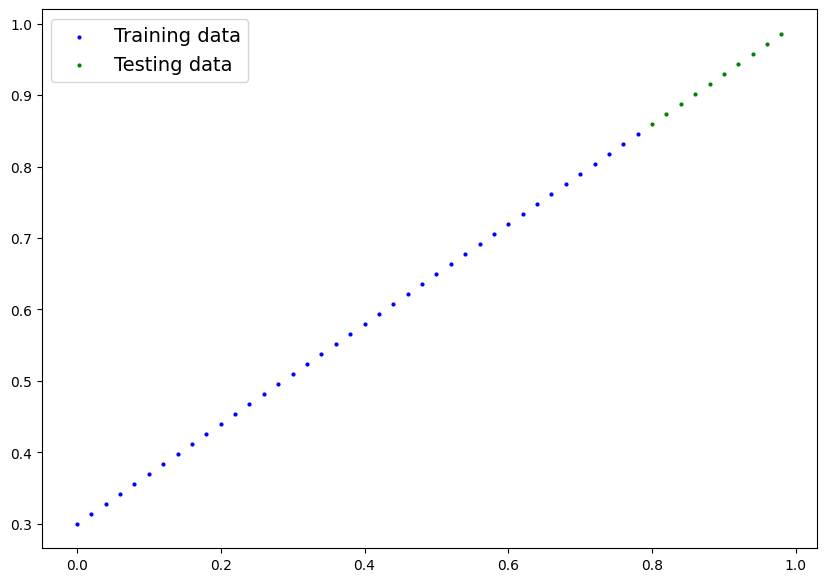

In [193]:
plot_predictions()

## 2. Build Model

python classes: https://realpython.com/python-classes/

What model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [194]:
from torch import nn

# Create linear regression model class

class LinearRegressionModel(nn.Module): # inheriting from nn.Module (base class for all neural network modules)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.rand(1,
                                        requires_grad=True,
                                        dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the content of our PyTorch model

let's see what we have inside

.parameters

In [195]:
# Create a random seed (to get the same random numbers)
torch.manual_seed(42)

# Create an instance of the model (this is subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [196]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.3904]))])

### Making prediction using `torch.inference_mode()`

when data passed through model, it is going to run through `forward()` method

In [197]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [198]:
# Make predictions with model
with torch.inference_mode(): # turns off grad_fn
  y_preds = model_0(X_test)

y_preds

tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])

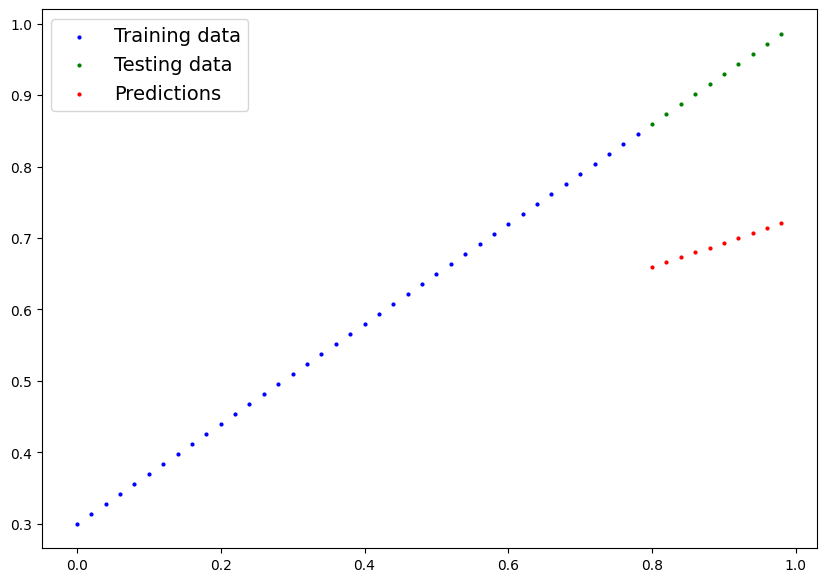

In [199]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some known parameters

Or in other words from a poor representation of the dat to a better representation of the data

One way to measure how poor or how wrong your model predictions are is to use loss functions

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameter (e.g. weight & bias in our case to improve the loss function)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [200]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [201]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stocastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), # model parameters to optimize
                            lr=0.01) # lr = learning rate - a hyperparameter that defines

In [202]:
loss_fn

L1Loss()

In [203]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Building a training loop (and a testing loop)

A couple of things we need in a training loop:
0. Loop through the data and do...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [204]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we have set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in Pytorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train) # loss_fn = nn.L1Loss()

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()


  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluatino/testing (dropout/batch norm layers
  with torch.inference_mode(): # turns off gradient tracking & a couple more things
    # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.08169572055339813 | Test loss: 0.22662055492401123
OrderedDict([('weights', tensor([0.3398])), ('bias', tensor([0.3939]))])
Epoch: 10 | Loss: 0.06808149069547653 | Test loss: 0.1807345449924469
OrderedDict([('weights', tensor([0.3672])), ('bias', tensor([0.4154]))])
Epoch: 20 | Loss: 0.06258393079042435 | Test loss: 0.15627031028270721
OrderedDict([('weights', tensor([0.3891])), ('bias', tensor([0.4204]))])
Epoch: 30 | Loss: 0.05879194289445877 | Test loss: 0.1418602615594864
OrderedDict([('weights', tensor([0.4081])), ('bias', tensor([0.4179]))])
Epoch: 40 | Loss: 0.05530194193124771 | Test loss: 0.13084018230438232
OrderedDict([('weights', tensor([0.4261])), ('bias', tensor([0.4129]))])
Epoch: 50 | Loss: 0.051822252571582794 | Test loss: 0.12050700187683105
OrderedDict([('weights', tensor([0.4439])), ('bias', tensor([0.4074]))])
Epoch: 60 | Loss: 0.04838593676686287 | Test loss: 0.11223447322845459
OrderedDict([('weights', tensor([0.4610])), ('bias', tensor([0.4004

In [205]:
weight, bias

(0.7, 0.3)

In [206]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6962])), ('bias', tensor([0.3064]))])

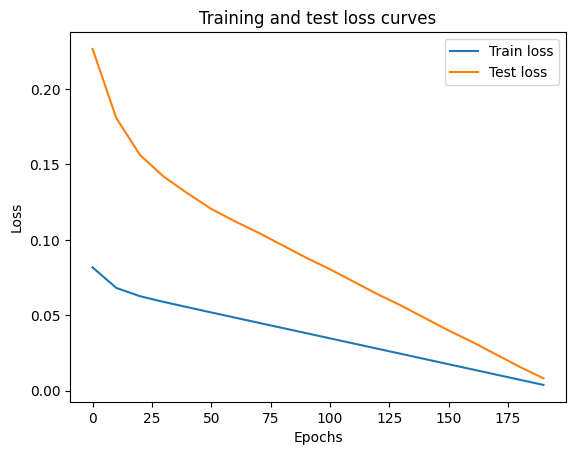

In [207]:
import numpy as np
np.array(torch.tensor(loss_values).numpy()), test_loss_values

# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [208]:
with torch.inference_mode():
  y_pred_new = model_0(X_test)

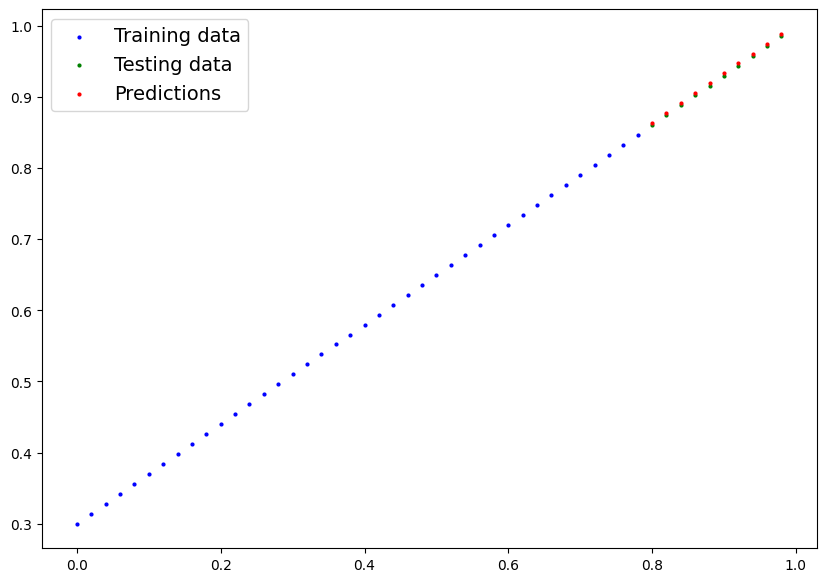

In [209]:
plot_predictions(predictions=y_pred_new)

## Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

PyTorch save & load code tutorial + extra-curriculum - https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [214]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict()
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_model_0.pth
